In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

print('Tensorflow version is ',tf.__version__)

Tensorflow version is  1.2.1


In [2]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('./data/mnist', one_hot=True) # download Mnist data

Extracting ./data/mnist\train-images-idx3-ubyte.gz
Extracting ./data/mnist\train-labels-idx1-ubyte.gz
Extracting ./data/mnist\t10k-images-idx3-ubyte.gz
Extracting ./data/mnist\t10k-labels-idx1-ubyte.gz


In [3]:
data_dim = mnist.train.images[0].shape[0] # 784
row = 28 # image's row
col = 28 # image's col

In [4]:
# get tensorflow session
def get_session():
    config = tf.ConfigProto()
    config.allow_soft_placement=True
    config.gpu_options.allow_growth = False
    config.log_device_placement=False
    sess = tf.Session(config = config)

    return sess

In [5]:
class VAE(object):
    def __init__(self, sess, name, learning_rate = 0.001, batch_size = 50, num_z = 10, layer1 = 512, layer2 = 256):
        self.sess = sess
        self.name = name
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.num_z = num_z
        self.layer1 = layer1
        self.layer2 = layer2
        
        
        self._build_net() # create variational autoencoder
        
        
    def _build_net(self):
        
        with tf.variable_scope(self.name):
            self.x = tf.placeholder(tf.float32, [None, data_dim])

            # encoder part (z_mean, z_log_sigma_sq)
            self.z_mean, self.z_log_sigma_sq = self.vae_encoder()
            
            # z = mu + sigma*epsilon
            self.eps, self.z = self.reparam()
            
            # decoder part
            self.x_recons = self.vae_decoder()
            
            # loss
            self.recons_loss, self.KLD, self.ELBO = self.vae_loss()
            
            # optimization
            self.optimizer = tf.train.AdamOptimizer(learning_rate = self.learning_rate).minimize(self.ELBO)
            
            return
            
    def vae_encoder(self):
        
        L1 = tf.layers.dense(inputs=self.x, units=self.layer1, activation=tf.nn.relu)
        L2 = tf.layers.dense(inputs=L1, units=self.layer2, activation=tf.nn.relu)
        
        z_mean = tf.layers.dense(inputs = L2, units = self.num_z, activation = None)
        z_log_sigma_sq = tf.layers.dense(inputs = L2, units = self.num_z, activation = None)
        
        return z_mean, z_log_sigma_sq
        
    def reparam(self):
        
        eps = tf.random_normal(tf.shape(self.z_log_sigma_sq), 0, 1, dtype = tf.float32)
        z = self.z_mean + tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps
        
        return eps, z
        
    def vae_decoder(self):

        L2_ = tf.layers.dense(inputs=self.z, units=self.layer2, activation = tf.nn.relu)
        L1_ = tf.layers.dense(inputs=L2_, units=self.layer1, activation = tf.nn.relu)

        x_recons = tf.layers.dense(inputs = L1_, units = data_dim, activation = tf.nn.sigmoid)

        return x_recons    
    
    def vae_loss(self):
        
        epsilon = 1e-10
        recons_loss = -tf.reduce_sum(self.x * tf.log(epsilon + self.x_recons)
                                    + (1-self.x) * tf.log(epsilon + 1 - self.x_recons), 1)
        # KL-divergence
        KLD = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq -tf.square(self.z_mean)
                                          -tf.exp(self.z_log_sigma_sq), 1)
        # Evidence lower bound
        ELBO = tf.reduce_mean(recons_loss + KLD)
        
        return recons_loss, KLD, ELBO
    
    # update parameters 
    def update_one_step(self, x):
        opt, ELBO, recons_loss, KLD \
            = self.sess.run([self.optimizer,  self.ELBO, self.recons_loss, self.KLD], \
                           feed_dict = {self.x:x})
            
        
        return ELBO, recons_loss, KLD
    
    # reconstruct input data
    def data_reconstruction(self, x):
        x_recons = self.sess.run(self.x_recons, feed_dict = {self.x:x})
        
        return x_recons
    
    # generate data using z(The data produced depends on z)
    def data_generation(self, z):
        x_generated = self.sess.run(self.x_recons, feed_dict = {self.z:z})
        
        return x_generated
    
    # returns z corresponding to input data
    def z_transform(self, x):
        
        return self.sess.run(self.z, feed_dict = {self.x:x})

In [6]:
sess = get_session()

In [7]:
# model parameter settings
m1 = {'model_name' : 'model1','learning_rate' : 0.001, 'batch_size' :  100, 'num_z' : 10, 'layer1' : 512, 'layer2' : 256}
m2 = {'model_name' : 'model2','learning_rate' : 0.001, 'batch_size' :  100, 'num_z' : 2, 'layer1' : 512, 'layer2' : 256}

m = [m1, m2]
model_nums = len(m)

In [8]:
init_models = []

for i in range(model_nums):
    init_models.append(VAE(sess,m[i]['model_name'], m[i]['learning_rate'], \
                          m[i]['batch_size'], m[i]['num_z'], m[i]['layer1'], m[i]['layer2']))

In [9]:
# initialize parameters
init = tf.global_variables_initializer()
sess.run(init)  

In [10]:
def trainer(model, epochs = 51):

    batch_size = model.batch_size
    for step in range(epochs):
        avg_loss = 0
        total_batch = int(mnist.train.num_examples/batch_size)
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
            ELBO, recons_loss, KLD = model.update_one_step(batch_xs)
            
            avg_loss += ELBO / total_batch
            
        if step%20 == 0:
            print('Epoch : {}, avg loss : {}'.format(step,avg_loss))
    return model

In [11]:
models = []

epochs = 101

for i in range(len(init_models)):
    print('{} Training now...'.format(init_models[i].name))
    models.append(trainer(init_models[i], epochs))
    print('=='*20, end='\n\n')

model1 Training now...
Epoch : 0, avg loss : 157.62170476740042
Epoch : 20, avg loss : 101.5735318825462
Epoch : 40, avg loss : 98.95063074285335
Epoch : 60, avg loss : 97.71659745649846
Epoch : 80, avg loss : 96.92075789018106
Epoch : 100, avg loss : 96.39834492076531

model2 Training now...
Epoch : 0, avg loss : 184.8903205455435
Epoch : 20, avg loss : 141.08306371515457
Epoch : 40, avg loss : 137.88096736561184
Epoch : 60, avg loss : 135.92326966719216
Epoch : 80, avg loss : 134.89239177357067
Epoch : 100, avg loss : 133.79527743252848



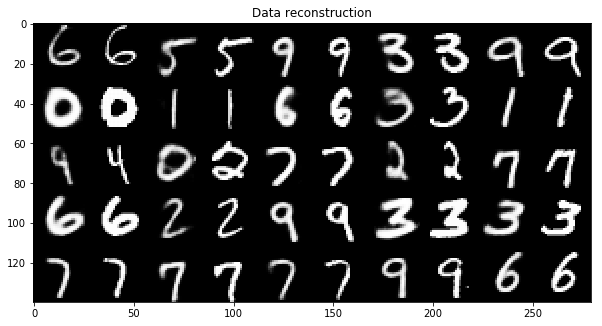

In [12]:
model = models[0]

display_num = 30

batch_data = mnist.test.next_batch(display_num)
x_reconstructed = model.data_reconstruction(batch_data[0])


n = np.sqrt(display_num).astype(np.int32)
reconstructed = np.empty((col*n, 2*row*n))
for i in range(n):
    for j in range(n):
        x = np.concatenate(
            (x_reconstructed[i*n+j, :].reshape(col, row), 
             batch_data[0][i*n+j, :].reshape(col, row)),
            axis=1
        )
        reconstructed[i*col:(i+1)*col, j*2*row:(j+1)*2*row] = x

plt.figure(figsize=(10, 20))
plt.title('Data reconstruction')
plt.imshow(reconstructed, cmap='gray')

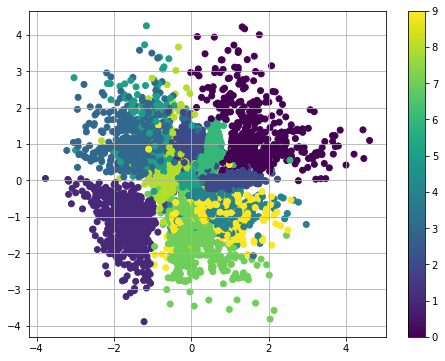

In [13]:
model_2z = models[1]

display_num = 5000

batch_xs, batch_ys = mnist.test.next_batch(display_num)
z = model_2z.z_transform(batch_xs)
plt.figure(figsize=(8, 6)) 
plt.scatter(z[:, 0], z[:, 1], c=np.argmax(batch_ys, 1))
plt.colorbar()
plt.grid()

In [14]:
print('x-axis : [{} {}]'.format(np.min(z[:,0]), np.max(z[:,0])))
print('y-axis : [{} {}]'.format(np.min(z[:,1]), np.max(z[:,1])))

x-axis : [-3.771228790283203 4.605858325958252]
y-axis : [-3.8894741535186768 4.248901844024658]


In [15]:
n = 25
x_max = np.max(z[:,0])
x_min = np.min(z[:,0])

y_max = np.max(z[:, 1])
y_min = np.min(z[:, 1])

x = np.linspace(x_min, x_max, n)
y = np.linspace(y_min, y_max, n)

z_generated = np.empty((col*n, row*n))

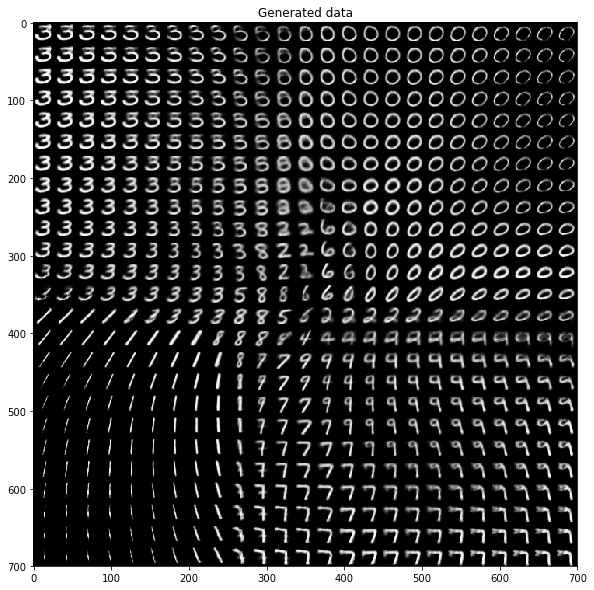

In [16]:
for i, yi in enumerate(x):
    for j, xi in enumerate(y):
        
        x_generated = model_2z.data_generation(np.array([xi,yi]).reshape(-1,2))
        z_generated[(n-i-1)*28:(n-i)*28, j*28:(j+1)*28] = x_generated[0].reshape(28, 28)

plt.figure(figsize=(10, 10))        
plt.title('Generated data')
plt.imshow(z_generated, cmap="gray")